# Computational Social Science Project #2 

*Group number:* Group 4

*Group members:* Laura Pathak, Irem Inal, Val Sierra

*Semester:* Fall 2021


Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send KQ a pull request on GitHub flagging the syntax that's tripping you up 

## 1. Introduction/Setup

#### a) Import relevant libraries
Add the other libraries you need for your code below and/or as you go. 

In [1]:
# import libraries you might need here 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns



# use random seed for consistent results 
np.random.seed(273)

#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. 

In [2]:
diabetes = pd.read_csv('Diabetes with Population Info by County 2017.csv', 
                       #CountyFips needs to be a string so leading 0 isn't dropped (this is only if you want to make choropleth map): 
                       dtype={"CountyFIPS": str})


In [3]:
# look at the dimensions of the diabetes data frame
print('shape: ', diabetes.shape) 

shape:  (3220, 95)


In [4]:
pd.set_option('display.max_rows', 100) # tells pandas how many rows to display when printing so results don't get truncated

# look at the data types for each column in diabetes df 
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total population

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [5]:
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes["Diabetes_Number"].str.isnumeric()]["Diabetes_Number"].unique()) 

['Suppressed']


In [6]:
# Now do the same as above, but for "Obesity_Number" :
print(diabetes[~diabetes["Obesity_Number"].str.isnumeric()]["Obesity_Number"].unique())

# Irem: doing the same for Physical_Inactivity_Number : 
print(diabetes[~diabetes["Physical_Inactivity_Number"].str.isnumeric()]["Physical_Inactivity_Number"].unique())


['No Data']
['No Data']


The values contained in the two columns above making them objects (rather than integers) appear to be strings like "No Data" and "Suppressed." Let's drop those rows in the next section, and also recode Physical_Inactivity_Number to be an integer. 

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' to. 

In [7]:
# Diabetes
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"]  # note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 
# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes['Diabetes_Number'] = diabetes['Diabetes_Number'].astype(int) 

# Obesity
diabetes = diabetes[diabetes['Obesity_Number']!= "No Data"]
diabetes['Obesity_Number'] = diabetes['Obesity_Number'].astype(int) 

# Physical Inactivity
diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].astype(int) 


# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]
# change to numeric (specifically, integer or float?) from string (because originally included the "-" )
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype(float)

#Irem: looking at data types again
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                           int64
Obesity_Number                                                                                                                                            int64
Physical_Inactivity_Number                                                                                                                                int64
sex and age_total population

We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [8]:
# select count variables to rc to percentages; make sure we leave out ratios and our population variable b/c these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 'sex and age_total population_sex ratio (males per 100 females)', 'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population']]
           
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') # recode all selected columns to numeric

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)

Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [9]:
pd.set_option('display.max_columns', None)
# inspect recoded values
diabetes_summary = diabetes[rc_cols].describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
  
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present

,count,mean,min,max
Diabetes_Number,3112.0,0.092857,0.019038,0.224208
Obesity_Number,3112.0,0.251666,0.088946,0.476788
Physical_Inactivity_Number,3112.0,0.200861,0.064949,0.392285
race_total population_one race,3112.0,0.976059,0.713126,1.000000
race_total population_two or more races,3112.0,0.023941,0.000000,0.286874
race_total population_one race_1,3112.0,0.976059,0.713126,1.000000
race_total population_one race_white,3112.0,0.831107,0.038912,1.000000
race_total population_one race_black or african american,3112.0,0.090215,0.000000,0.874123
race_total population_one race_american indian and alaska native,3112.0,0.019398,0.000000,0.924799
race_total population_one race_american indian and alaska native_cherokee tribal grouping,3112.0,0.001791,0.000000,0.409669


#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. 

In [10]:
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['sex and age_total population',
 'sex and age_total population_65 years and over_1',
 'hispanic or latino and race_total population',
 'race_total population_one race_1',
 'race_total population_two or more races_1',
 'sex and age_total population_18 years and over_1']

In [11]:
# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(columns=['sex and age_total population_18 years and over_1',
 'race_total population_one race_1',
 'hispanic or latino and race_total population',
 'race_total population_two or more races_1',
 'sex and age_total population_65 years and over_1',
 'sex and age_total population']) 

**KQ**: here, rather than hardcode the column names in, you might have just written the list `duplicateColumnNames` instead. 

## 2. Exploratory Data Analysis

In [13]:
# let's look at the number of counties in each state
state_counts = diabetes.groupby('State', as_index=False)['County'].count()
state_counts

,State,County
0,Alabama,67
1,Alaska,29
2,Arizona,15
3,Arkansas,74
4,California,58
5,Colorado,64
6,Connecticut,8
7,Delaware,3
8,District of Columbia,1
9,Florida,67


In [14]:
# now, let's look at the counties with the *highest* levels of diabetes, physical inactivity, and obesity
top10_diabetes = diabetes[["County","State","CountyFIPS","Diabetes_Number"]].sort_values('Diabetes_Number', ascending=False).head(10)
top10_diabetes

,County,State,CountyFIPS,Diabetes_Number
5,Bullock County,Alabama,01011,0.224208
144,Jackson County,Arkansas,05067,0.222119
1941,Jones County,North Carolina,37103,0.213306
2183,Nowata County,Oklahoma,40105,0.210440
520,Telfair County,Georgia,13271,0.207757
18,Coosa County,Alabama,01037,0.207278
184,Woodruff County,Arkansas,05147,0.205105
516,Talbot County,Georgia,13263,0.202885
1126,Claiborne Parish,Louisiana,22027,0.201944
456,Hancock County,Georgia,13141,0.192150


In [15]:
top10_obesity = diabetes[["County","State","CountyFIPS","Obesity_Number"]].sort_values('Obesity_Number', ascending=False).head(10)
top10_obesity

,County,State,CountyFIPS,Obesity_Number
67,Aleutians East Borough,Alaska,02013,0.476788
2184,Okfuskee County,Oklahoma,40107,0.438217
1467,Sunflower County,Mississippi,28133,0.394316
407,Candler County,Georgia,13043,0.387457
2962,King And Queen County,Virginia,51097,0.387408
43,Macon County,Alabama,01087,0.386690
535,Warren County,Georgia,13301,0.378975
1926,Gates County,North Carolina,37073,0.377930
469,Johnson County,Georgia,13167,0.377903
1432,Jefferson County,Mississippi,28063,0.375715


In [16]:
top10_pa = diabetes[["County","State","CountyFIPS","Physical_Inactivity_Number"]].sort_values('Physical_Inactivity_Number',ascending=False).head(10)
top10_pa

,County,State,CountyFIPS,Physical_Inactivity_Number
169,Prairie County,Arkansas,05117,0.392285
1806,Harding County,New Mexico,35021,0.379085
333,Dixie County,Florida,12029,0.350916
160,Nevada County,Arkansas,05099,0.341706
3099,Mingo County,West Virginia,54059,0.338709
1470,Tippah County,Mississippi,28139,0.329650
480,Macon County,Georgia,13193,0.328783
112,Ashley County,Arkansas,05003,0.327945
1463,Sharkey County,Mississippi,28125,0.327200
17,Conecuh County,Alabama,01035,0.326275


In [17]:
# let's look at avg rates of diabates, obesity, and physical inactivity
state_means = diabetes.groupby('State', as_index=False)['Diabetes_Number','Obesity_Number','Physical_Inactivity_Number'].mean().rename(columns = {'Diabetes_Number': 'Avg Diabetes Rate','Obesity_Number': 'Avg Obesity Rate','Physical_Inactivity_Number':'Avg Physical Inactivity Rate'})
state_means

# sorted by avg diabetes rate, highest to lowest
state_means_sorted = state_means.sort_values('Avg Diabetes Rate',ascending=False)
state_means_sorted

<ipython-input-17-f52b44d9cecd>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  state_means = diabetes.groupby('State', as_index=False)['Diabetes_Number','Obesity_Number','Physical_Inactivity_Number'].mean().rename(columns = {'Diabetes_Number': 'Avg Diabetes Rate','Obesity_Number': 'Avg Obesity Rate','Physical_Inactivity_Number':'Avg Physical Inactivity Rate'})


,State,Avg Diabetes Rate,Avg Obesity Rate,Avg Physical Inactivity Rate
0,Alabama,0.127640,0.288034,0.239948
40,South Carolina,0.120790,0.286474,0.225997
48,West Virginia,0.119494,0.292064,0.220353
24,Mississippi,0.118071,0.299233,0.238497
3,Arkansas,0.112904,0.271585,0.250961
42,Tennessee,0.109382,0.266088,0.229609
10,Georgia,0.109146,0.259649,0.226371
33,North Carolina,0.106442,0.263668,0.207701
18,Louisiana,0.106157,0.284379,0.224360
9,Florida,0.102635,0.251093,0.239596


Text(0.5, 1.0, 'Top 10 Average Rates by State')

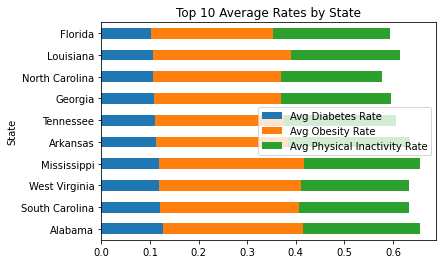

In [18]:
# let's make bar plot of the 10 states with highest average diabetes rates, along with their obesity and physical inactivity rates
state_means_sorted.head(10).plot.barh(x=0, stacked=True)
plt.title('Top 10 Average Rates by State')

**KQ**: what does this graph tell us? 

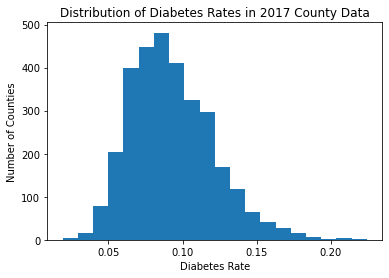

In [19]:
# let's look at the distributions of these variables
# histogram of Diabetes_Number (label)
plt.title('Distribution of Diabetes Rates in 2017 County Data')
plt.xlabel('Diabetes Rate')
plt.hist(diabetes['Diabetes_Number'], bins=20);
plt.ylabel('Number of Counties');

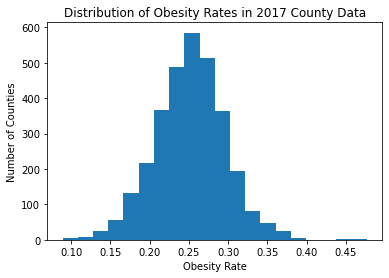

In [20]:
# histogram of Obesity_Number (feature)
plt.title('Distribution of Obesity Rates in 2017 County Data')
plt.xlabel('Obesity Rate')
plt.hist(diabetes['Obesity_Number'], bins=20);
plt.ylabel('Number of Counties');

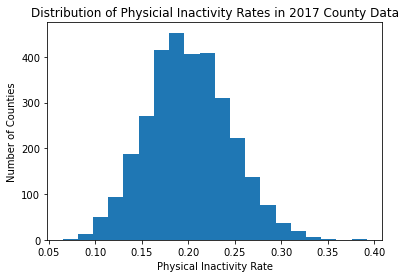

In [21]:
# histogram of Physical_Inactivity_Number (feature)
plt.title('Distribution of Physicial Inactivity Rates in 2017 County Data')
plt.xlabel('Physical Inactivity Rate')
plt.hist(diabetes['Physical_Inactivity_Number'], bins=20);
plt.ylabel('Number of Counties');

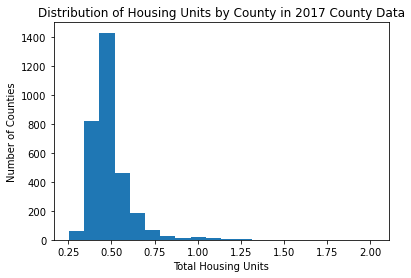

In [22]:
# histogram of total housing units (feature)
plt.title('Distribution of Housing Units by County in 2017 County Data')
plt.xlabel('Total Housing Units')
plt.hist(diabetes['total housing units'], bins=20);
plt.ylabel('Number of Counties');

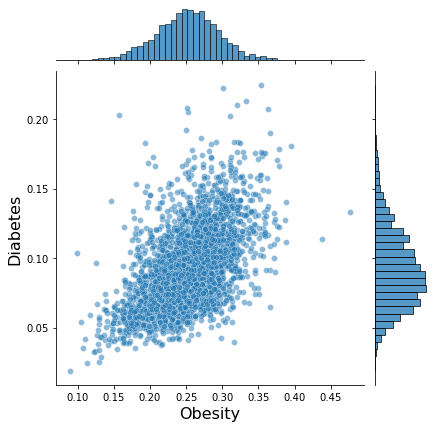

In [23]:
# let's look at the relationships between diabetes and various features
# scatterplot of diabetes and obesity
diabetes_obesity_plot = sns.jointplot(x = 'Obesity_Number', y = 'Diabetes_Number', data = diabetes, alpha = .5)
diabetes_obesity_plot.set_axis_labels('Obesity', 'Diabetes', fontsize=16)

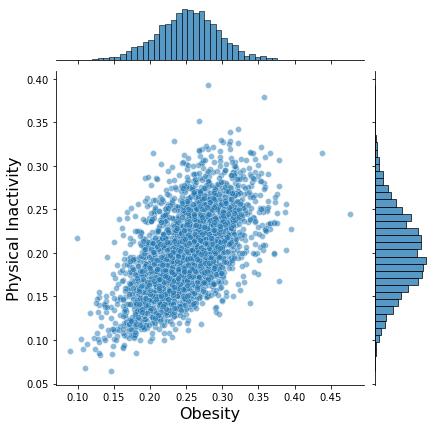

In [24]:
# scatterplot of obesity and physical inactivity
obesity_pa_plot = sns.jointplot(x = 'Obesity_Number', y = 'Physical_Inactivity_Number', data = diabetes, alpha = .5)
obesity_pa_plot.set_axis_labels('Obesity', 'Physical Inactivity', fontsize=16)

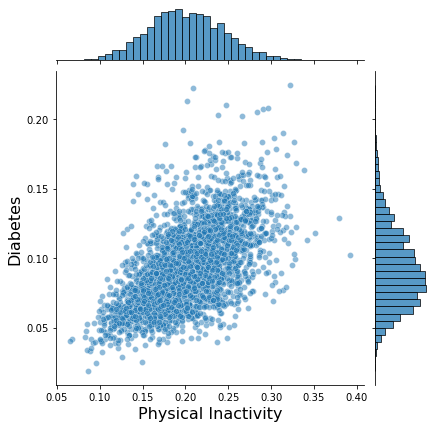

In [25]:
# scatterplot of diabetes and physical inactivity
diabetes_pa_plot = sns.jointplot(x = 'Physical_Inactivity_Number', y = 'Diabetes_Number', data = diabetes, alpha = .5)
diabetes_pa_plot.set_axis_labels('Physical Inactivity', 'Diabetes', fontsize=16)

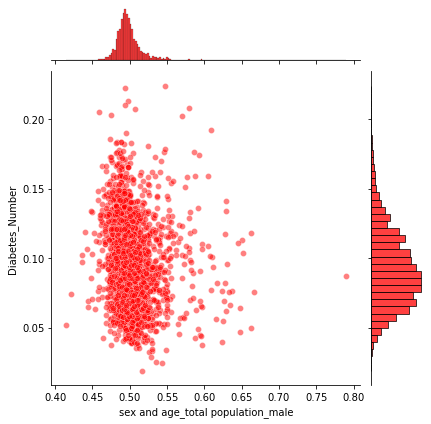

In [26]:
# scatterplots of diabetes and males
diabetes_male_plot = sns.jointplot(x = 'sex and age_total population_male', y = 'Diabetes_Number', data = diabetes, alpha = .5, color='red')
diabetes_pa_plot.set_axis_labels('Proportion of Males', 'Diabetes', fontsize=16)

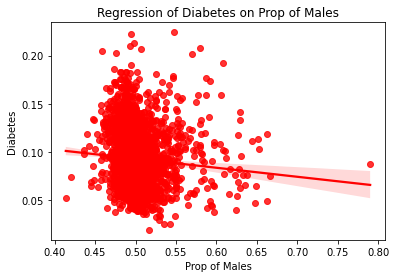

In [27]:
sns.regplot(x='sex and age_total population_male', y='Diabetes_Number', data=diabetes, color='red')
plt.title('Regression of Diabetes on Prop of Males')
plt.xlabel('Prop of Males')
plt.ylabel('Diabetes');

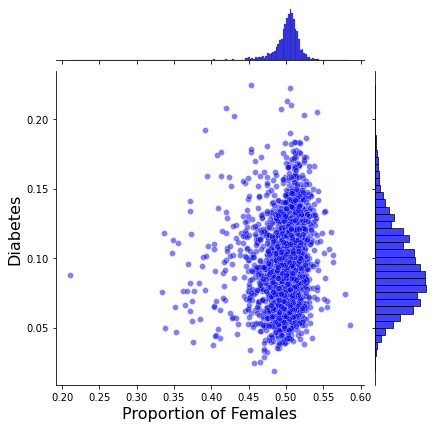

In [28]:
# scatterplots of diabetes and females
diabetes_female_plot = sns.jointplot(x = 'sex and age_total population_female', y = 'Diabetes_Number', data = diabetes, alpha = .5, color='blue')
diabetes_female_plot.set_axis_labels('Proportion of Females', 'Diabetes', fontsize=16)

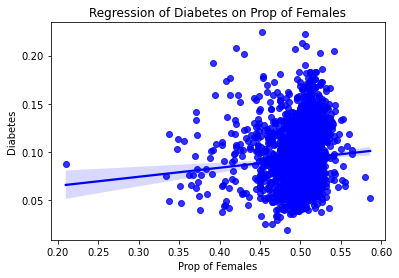

In [29]:
sns.regplot(x='sex and age_total population_female', y='Diabetes_Number', data=diabetes, color='blue')
plt.title('Regression of Diabetes on Prop of Females')
plt.xlabel('Prop of Females')
plt.ylabel('Diabetes');

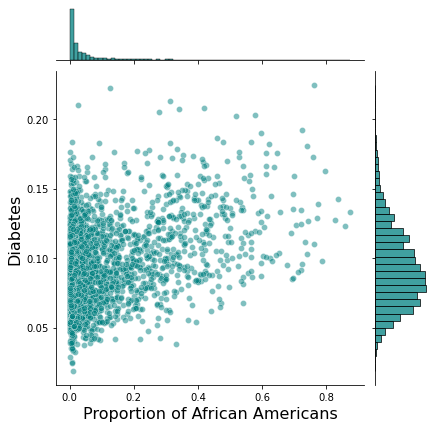

In [30]:
# scatterplots of diabetes and African Americans
diabetes_AA_plot = sns.jointplot(x = 'race_total population_one race_black or african american', y = 'Diabetes_Number', data = diabetes, alpha = .5, color='teal')
diabetes_AA_plot.set_axis_labels('Proportion of African Americans', 'Diabetes', fontsize=16)

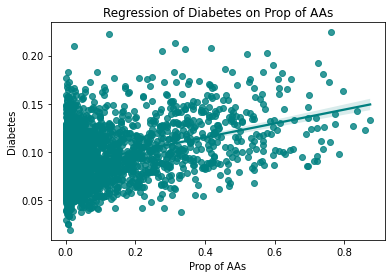

In [31]:
sns.regplot(x='race_total population_one race_black or african american', y='Diabetes_Number', data=diabetes, color='teal')
plt.title('Regression of Diabetes on Prop of AAs')
plt.xlabel('Prop of AAs')
plt.ylabel('Diabetes');

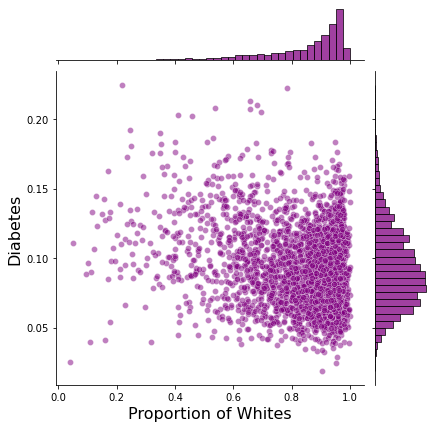

In [32]:
# scatterplots of diabetes and whites
diabetes_whites_plot = sns.jointplot(x = 'race_total population_one race_white', y = 'Diabetes_Number', data = diabetes, alpha = .5, color='purple')
diabetes_whites_plot.set_axis_labels('Proportion of Whites', 'Diabetes', fontsize=16)

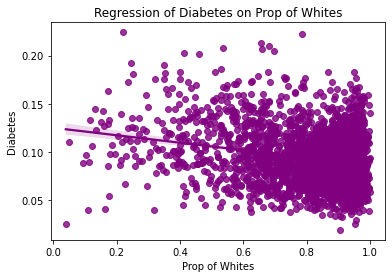

In [33]:
sns.regplot(x='race_total population_one race_white', y='Diabetes_Number', data=diabetes, color='purple')
plt.title('Regression of Diabetes on Prop of Whites')
plt.xlabel('Prop of Whites')
plt.ylabel('Diabetes');

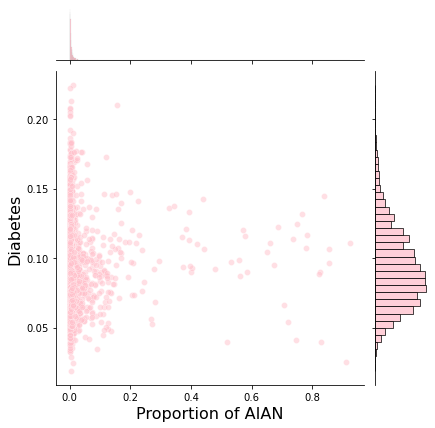

In [34]:
# scatterplots of diabetes and AIAN
diabetes_AIAN_plot = sns.jointplot(x = 'race_total population_one race_american indian and alaska native', y = 'Diabetes_Number', data = diabetes, alpha = .5, color='pink')
diabetes_AIAN_plot.set_axis_labels('Proportion of AIAN', 'Diabetes', fontsize=16)

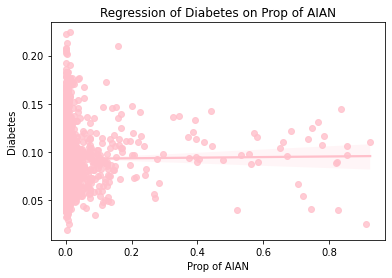

In [35]:
sns.regplot(x='race_total population_one race_american indian and alaska native', y='Diabetes_Number', data=diabetes, color='pink')
plt.title('Regression of Diabetes on Prop of AIAN')
plt.xlabel('Prop of AIAN')
plt.ylabel('Diabetes');

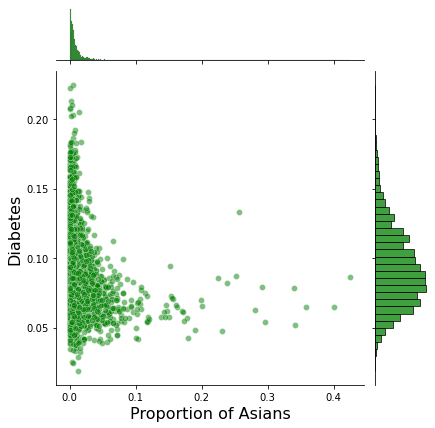

In [36]:
# scatterplots of diabetes and Asians
diabetes_Asians_plot = sns.jointplot(x = 'race_total population_one race_asian', y = 'Diabetes_Number', data = diabetes, alpha = .5, color='green')
diabetes_Asians_plot.set_axis_labels('Proportion of Asians', 'Diabetes', fontsize=16)

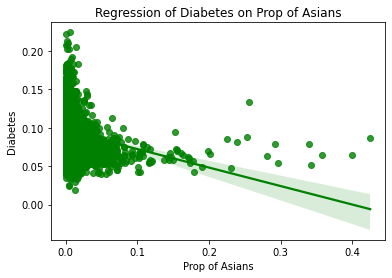

In [37]:
sns.regplot(x='race_total population_one race_asian', y='Diabetes_Number', data=diabetes, color='green')
plt.title('Regression of Diabetes on Prop of Asians')
plt.xlabel('Prop of Asians')
plt.ylabel('Diabetes');

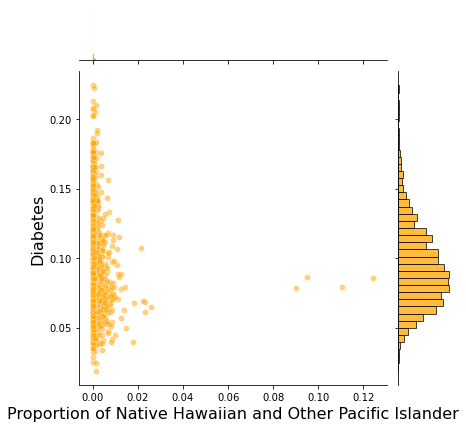

In [38]:
# scatterplots of diabetes and native hawaiian and other pacific islander
diabetes_API_plot = sns.jointplot(x = 'race_total population_one race_native hawaiian and other pacific islander', y = 'Diabetes_Number', data = diabetes, alpha = .5, color='orange')
diabetes_API_plot.set_axis_labels('Proportion of Native Hawaiian and Other Pacific Islander', 'Diabetes', fontsize=16)

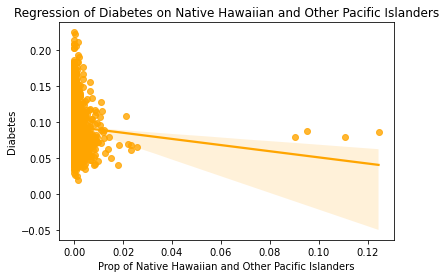

In [39]:
sns.regplot(x='race_total population_one race_native hawaiian and other pacific islander', y='Diabetes_Number', data=diabetes, color='orange')
plt.title('Regression of Diabetes on Native Hawaiian and Other Pacific Islanders')
plt.xlabel('Prop of Native Hawaiian and Other Pacific Islanders')
plt.ylabel('Diabetes');

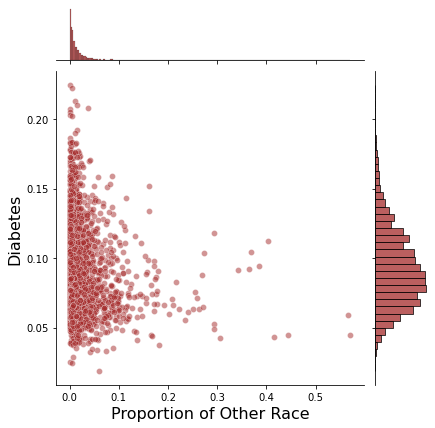

In [40]:
# scatterplots of diabetes and Other race
diabetes_Other_plot = sns.jointplot(x = 'race_total population_one race_some other race', y = 'Diabetes_Number', data = diabetes, alpha = .5, color='brown')
diabetes_Other_plot.set_axis_labels('Proportion of Other Race', 'Diabetes', fontsize=16)

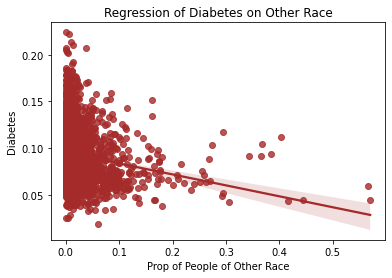

In [41]:
sns.regplot(x='race_total population_one race_some other race', y='Diabetes_Number', data=diabetes, color='brown')
plt.title('Regression of Diabetes on Other Race')
plt.xlabel('Prop of People of Other Race')
plt.ylabel('Diabetes');

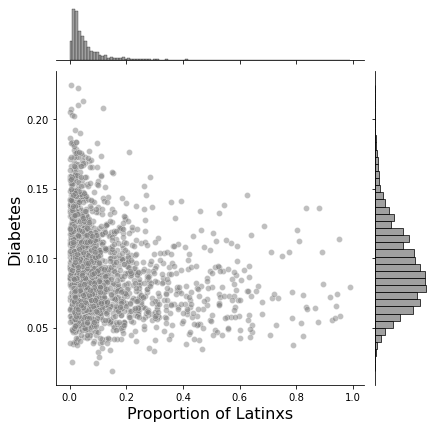

In [42]:
# scatterplots of diabetes and Latinxs
diabetes_Other_plot = sns.jointplot(x = 'hispanic or latino and race_total population_hispanic or latino (of any race)', y = 'Diabetes_Number', data = diabetes, alpha = .5, color='gray')
diabetes_Other_plot.set_axis_labels('Proportion of Latinxs', 'Diabetes', fontsize=16)

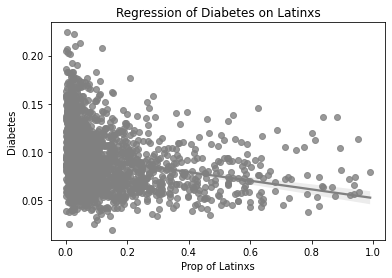

In [43]:
sns.regplot(x='hispanic or latino and race_total population_hispanic or latino (of any race)', y='Diabetes_Number', data=diabetes, color='gray')
plt.title('Regression of Diabetes on Latinxs')
plt.xlabel('Prop of Latinxs')
plt.ylabel('Diabetes');

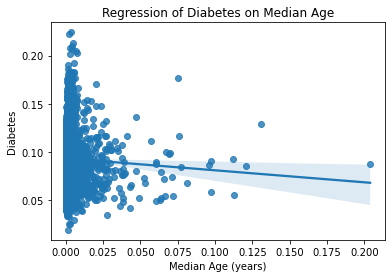

In [44]:
# scatterplot of diabetes and median age
sns.regplot(x='sex and age_total population_median age (years)', y='Diabetes_Number', data=diabetes)
plt.title('Regression of Diabetes on Median Age')
plt.xlabel('Median Age (years)')
plt.ylabel('Diabetes');

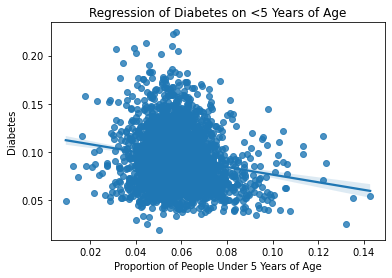

In [45]:
# the following are scatterplots of diabetes and different age groups
sns.regplot(x='sex and age_total population_under 5 years', y='Diabetes_Number', data=diabetes)
plt.title('Regression of Diabetes on <5 Years of Age')
plt.xlabel('Proportion of People Under 5 Years of Age')
plt.ylabel('Diabetes');

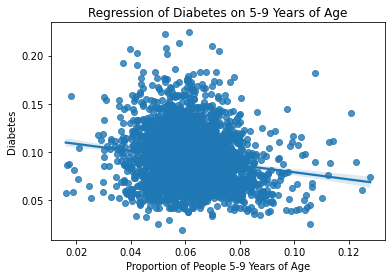

In [46]:
sns.regplot(x='sex and age_total population_5 to 9 years', y='Diabetes_Number', data=diabetes)
plt.title('Regression of Diabetes on 5-9 Years of Age')
plt.xlabel('Proportion of People 5-9 Years of Age')
plt.ylabel('Diabetes');

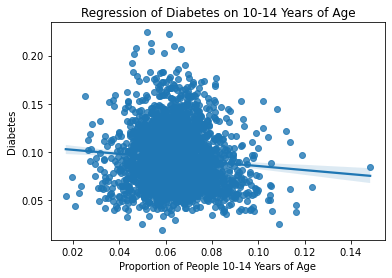

In [47]:
sns.regplot(x='sex and age_total population_10 to 14 years', y='Diabetes_Number', data=diabetes)
plt.title('Regression of Diabetes on 10-14 Years of Age')
plt.xlabel('Proportion of People 10-14 Years of Age')
plt.ylabel('Diabetes');

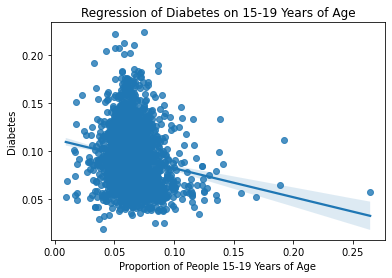

In [48]:
sns.regplot(x='sex and age_total population_15 to 19 years', y='Diabetes_Number', data=diabetes)
plt.title('Regression of Diabetes on 15-19 Years of Age')
plt.xlabel('Proportion of People 15-19 Years of Age')
plt.ylabel('Diabetes');

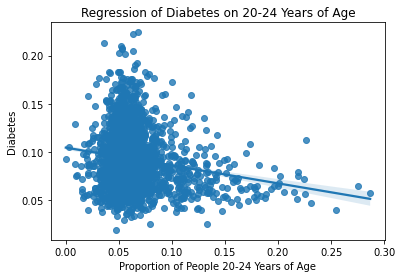

In [49]:
sns.regplot(x='sex and age_total population_20 to 24 years', y='Diabetes_Number', data=diabetes)
plt.title('Regression of Diabetes on 20-24 Years of Age')
plt.xlabel('Proportion of People 20-24 Years of Age')
plt.ylabel('Diabetes');

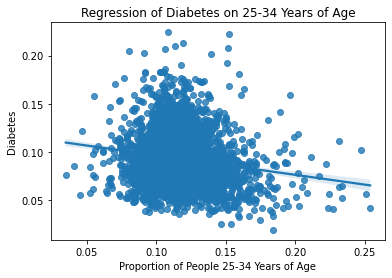

In [50]:
sns.regplot(x='sex and age_total population_25 to 34 years', y='Diabetes_Number', data=diabetes)
plt.title('Regression of Diabetes on 25-34 Years of Age')
plt.xlabel('Proportion of People 25-34 Years of Age')
plt.ylabel('Diabetes');

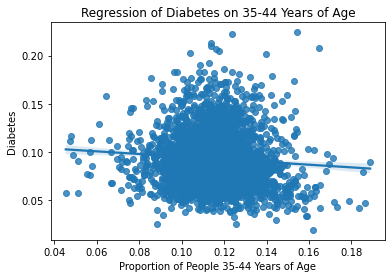

In [51]:
sns.regplot(x='sex and age_total population_35 to 44 years', y='Diabetes_Number', data=diabetes)
plt.title('Regression of Diabetes on 35-44 Years of Age')
plt.xlabel('Proportion of People 35-44 Years of Age')
plt.ylabel('Diabetes');

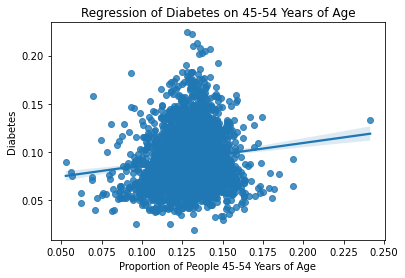

In [52]:
sns.regplot(x='sex and age_total population_45 to 54 years', y='Diabetes_Number', data=diabetes)
plt.title('Regression of Diabetes on 45-54 Years of Age')
plt.xlabel('Proportion of People 45-54 Years of Age')
plt.ylabel('Diabetes');

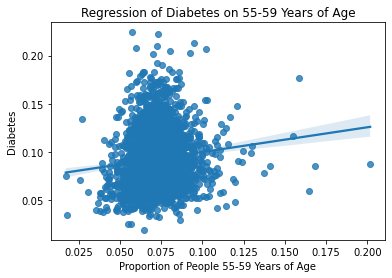

In [53]:
sns.regplot(x='sex and age_total population_55 to 59 years', y='Diabetes_Number', data=diabetes)
plt.title('Regression of Diabetes on 55-59 Years of Age')
plt.xlabel('Proportion of People 55-59 Years of Age')
plt.ylabel('Diabetes');

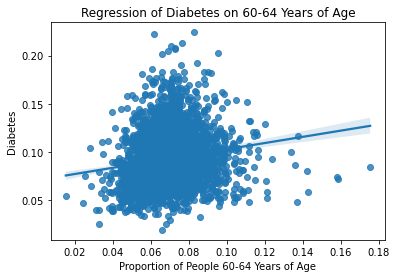

In [54]:
sns.regplot(x='sex and age_total population_60 to 64 years', y='Diabetes_Number', data=diabetes)
plt.title('Regression of Diabetes on 60-64 Years of Age')
plt.xlabel('Proportion of People 60-64 Years of Age')
plt.ylabel('Diabetes');

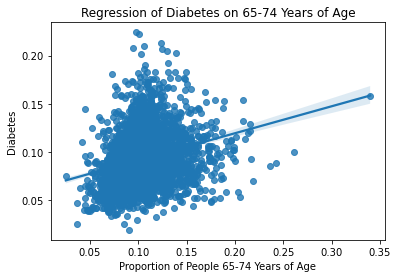

In [55]:
sns.regplot(x='sex and age_total population_65 to 74 years', y='Diabetes_Number', data=diabetes)
plt.title('Regression of Diabetes on 65-74 Years of Age')
plt.xlabel('Proportion of People 65-74 Years of Age')
plt.ylabel('Diabetes');

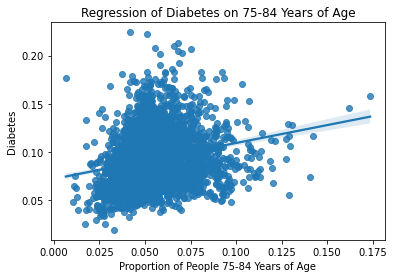

In [56]:
sns.regplot(x='sex and age_total population_75 to 84 years', y='Diabetes_Number', data=diabetes)
plt.title('Regression of Diabetes on 75-84 Years of Age')
plt.xlabel('Proportion of People 75-84 Years of Age')
plt.ylabel('Diabetes');

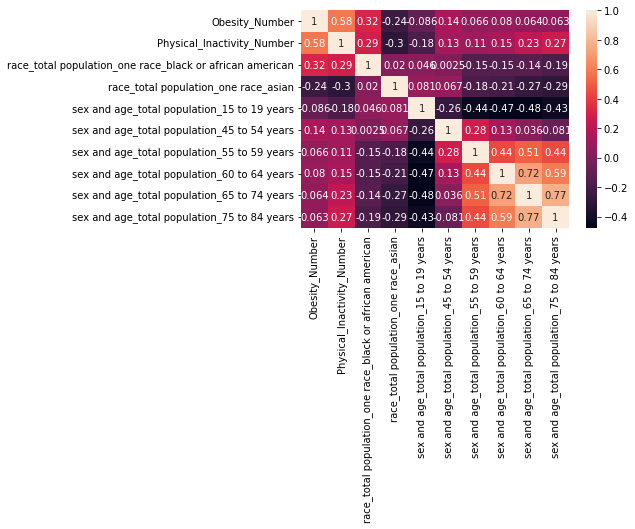

In [57]:
# From the Exploratory Data Analysis we can see that the following variables maybe be correlated with diabetes rates:
'Obesity_Number'
'Physical_Inactivity_Number'
'race_total population_one race_black or african american'
'race_total population_one race_asian'
'sex and age_total population_15 to 19 years'
'sex and age_total population_45 to 54 years'
'sex and age_total population_55 to 59 years'
'sex and age_total population_60 to 64 years'
'sex and age_total population_65 to 74 years'
'sex and age_total population_75 to 84 years'

#Looking at the correlation matrix to avoid multicollinearity
df = pd.DataFrame(diabetes,columns=['Obesity_Number',
'Physical_Inactivity_Number',
'race_total population_one race_black or african american',
'race_total population_one race_asian',
'sex and age_total population_15 to 19 years',
'sex and age_total population_45 to 54 years',
'sex and age_total population_55 to 59 years',
'sex and age_total population_60 to 64 years',
'sex and age_total population_65 to 74 years',
'sex and age_total population_75 to 84 years'])
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

**KQ**: I really appreciate your use of the correlation matrix at the end to look at relationships between variables. This is always a useful graph to look at before deploying any ML algorithm. These graphs are very thorough and do a nice job visualizing features and relationships several different ways. For future projects, I would say it's better to provide just a few plots and dig into analyzing them and what they mean for the problem at hand. 

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'State' to be a categorical variable using `pd.get_dummies` and drop 'County' using `.drop()` because 'CountyFIPS' is already a unique identifier for the county. 

We also remove CountyFIPS in this step, as this feature would have to be transformed into a large number of dummy variables in order to be analysed while at the same time increasing model complexity tremendously. In fact, we first trained our models with county dummies, but this led to computation errors in the hyperparameter tuning phase. As we will explain in part 6, removing county feature does not compromise the predictive performance of our models for this case.

In [62]:
# create dummy features out of 'State' , which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(diabetes, 
                               columns = ['State'],  
                               drop_first = True) # only create 49 dummies by dropping first in category

# drop 'County' variable as well as 'CountyFIPS'
diabetes_clean = diabetes_clean.drop(labels = ['County', 'CountyFIPS'],
                               axis =1) # which axis tells python we want to drop columns rather than index rows?


# look at first 10 rows of new data frame 
diabetes_clean.head(n=10) 

,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race - and three 

### 3.2/3.3 Partition Data and Feature Selection

Our EDA in the previous section revealed that counties where black & African American people are a higher proportion of the population are more likely to have high diabetes rates, while the relative population of Asians is negatively correlated with diabetes in a county. While there seems to be some correlation between other general racial groups (white, latinx, AIAN, NHPI and other) and diabetes, the slopes of the regression line for these groups seems to be not as upward/downward looking as the black & African American and Asian groups, and mostly sensitive to outliers. Therefore we remove all racial groups except those in the first feature selection phase before training our models. Similarly, looking at regression lines of age groups, variables indicating the 20-44 year old range as well as 0-15 year old range seem to be not worth taking into account for sake of simplicity in our models. Finally, we also remove features indicative of gender as these also look uncorrelated with diabetes, our label.

After dropping features mentioned above, we will partition our data to prepare it for the training process. We will use 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

**KQ**: I would caution you about removing so many features from the data set before training any models. There might be relationships between variables (i.e., information) that your models might detect. This is where the iterative process comes in. You might want to compare a reduced model to a full set, which you can't do if you remove so many features from the getgo. 

In [63]:
# Here is where we also drop irrelevant variables based on our EDA
list(diabetes_clean.columns)
diabetes_clean = diabetes_clean.drop(['sex and age_total population_65 years and over_sex ratio (males per 100 females)',
 'race_total population',
 'race_total population_one race',
 'race_total population_two or more races',
 'race_total population_one race_white',
 'race_total population_one race_american indian and alaska native',
 'race_total population_one race_american indian and alaska native_cherokee tribal grouping',
 'race_total population_one race_american indian and alaska native_chippewa tribal grouping',
 'race_total population_one race_american indian and alaska native_navajo tribal grouping',
 'race_total population_one race_american indian and alaska native_sioux tribal grouping',
 'race_total population_one race_asian_asian indian',
 'race_total population_one race_asian_chinese',
 'race_total population_one race_asian_filipino',
 'race_total population_one race_asian_japanese',
 'race_total population_one race_asian_korean',
 'race_total population_one race_asian_vietnamese',
 'race_total population_one race_asian_other asian',
 'race_total population_one race_native hawaiian and other pacific islander',
 'race_total population_one race_native hawaiian and other pacific islander_native hawaiian',
 'race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro',
 'race_total population_one race_native hawaiian and other pacific islander_samoan',
 'race_total population_one race_native hawaiian and other pacific islander_other pacific islander',
 'race_total population_one race_some other race',
 'race_total population_two or more races_white and black or african american',
 'race_total population_two or more races_white and american indian and alaska native',
 'race_total population_two or more races_white and asian',
 'race_total population_two or more races_black or african american and american indian and alaska native',
 'race alone or in combination with one or more other races_total population',
 'race alone or in combination with one or more other races_total population_white',
 'race alone or in combination with one or more other races_total population_black or african american',
 'race alone or in combination with one or more other races_total population_american indian and alaska native',
 'race alone or in combination with one or more other races_total population_asian',
 'race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander',
 'race alone or in combination with one or more other races_total population_some other race',
 'hispanic or latino and race_total population_hispanic or latino (of any race)',
 'hispanic or latino and race_total population_hispanic or latino (of any race)_mexican',
 'hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican',
 'hispanic or latino and race_total population_hispanic or latino (of any race)_cuban',
 'hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino',
 'hispanic or latino and race_total population_not hispanic or latino',
 'hispanic or latino and race_total population_not hispanic or latino_white alone',
 'hispanic or latino and race_total population_not hispanic or latino_black or african american alone',
 'hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone',
 'hispanic or latino and race_total population_not hispanic or latino_asian alone',
 'hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone',
 'hispanic or latino and race_total population_not hispanic or latino_some other race alone',
 'hispanic or latino and race_total population_not hispanic or latino_two or more races',
 'hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race',
 'hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -  and three or more races',                                    
 'sex and age_total population_under 5 years',
 'sex and age_total population_5 to 9 years',
 'sex and age_total population_10 to 14 years',
 'sex and age_total population_20 to 24 years',
 'sex and age_total population_25 to 34 years',
 'sex and age_total population_35 to 44 years',
 'sex and age_total population_18 years and over_male',
 'sex and age_total population_18 years and over_female',
 'sex and age_total population_18 years and over_sex ratio (males per 100 females)',
 'sex and age_total population_65 years and over_male',
 'sex and age_total population_65 years and over_female'], axis = 1)

In [64]:
# Checking the list of our features in the final data set and their types
print('data types:', diabetes_clean.dtypes)

data types: Diabetes_Number                                                              float64
Obesity_Number                                                               float64
Physical_Inactivity_Number                                                   float64
race_total population_one race_black or african american                     float64
race_total population_one race_asian                                         float64
total housing units                                                          float64
citizen -  voting age population_citizen -  18 and over population           float64
citizen -  voting age population_citizen -  18 and over population_male      float64
citizen -  voting age population_citizen -  18 and over population_female    float64
sex and age_total population_male                                            float64
sex and age_total population_female                                          float64
sex and age_total population_sex ratio (males per 100

In [65]:
from sklearn.model_selection import train_test_split

# Set y 
y = diabetes_clean['Diabetes_Number']

# X (Dropping diabetes, our target)
X = diabetes_clean.drop(['Diabetes_Number'], 
                axis = 1)

Xdf = diabetes_clean.drop(['Diabetes_Number'], #We creade this variable to retain X as data frame
                axis = 1)

We should also preprocess our data. Using the `preprocessing` module from sklearn, let's scale our features so that they are mean-centered.

In [66]:
from sklearn import preprocessing

X = preprocessing.scale(X) #When we do this, X becomes a numpy array instead of df, which causes problems in selecting columns

We can also get rid of the 0 variance features using the `VarianceThreshold()` method from `feature_selection`. 

In [67]:
from sklearn import feature_selection

selector = feature_selection.VarianceThreshold(0)
X = selector.fit_transform(X) #Similarly, X is a numpy array at the end of this operation
X

array([[-0.16471873,  0.58515483,  0.70134921, ..., -0.13288567,
        -0.15389675, -0.08242523],
       [-0.4154411 , -0.19181486,  0.03296023, ..., -0.13288567,
        -0.15389675, -0.08242523],
       [ 1.33084974,  0.21998678,  2.67247927, ..., -0.13288567,
        -0.15389675, -0.08242523],
       ...,
       [-0.28640652, -0.67657217, -0.6186219 , ..., -0.13288567,
        -0.15389675, 12.13220822],
       [-0.85439566,  0.20787775, -0.62449608, ..., -0.13288567,
        -0.15389675, 12.13220822],
       [ 0.72518908, -0.1364354 , -0.59020199, ..., -0.13288567,
        -0.15389675, 12.13220822]])

And finally, let's split our data:

In [68]:
# split the data
# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split? 

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.80, test_size=0.20)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train,
                                                    train_size=0.75, test_size=0.25)


In [69]:
#Irem: checking shapes

print("Shape of X train is", X_train.shape)
print("Shape of y_train is", y_train.shape)
print("Shape of X_validate is", X_validate.shape)
print("Shape of y_validate is", y_validate.shape)
print("Shape of X_test is", X_test.shape)
print("Shape of y_test is", y_test.shape)

Shape of X train is (1866, 75)
Shape of y_train is (1866,)
Shape of X_validate is (623, 75)
Shape of y_validate is (623,)
Shape of X_test is (623, 75)
Shape of y_test is (623,)


## 4. Train Models

### 4.1 Model Description

OLS:  This model the relationship between the features and the label (diabates rate) by minimizing the sum of the squares in the difference between the observed and predicted values of the label configured as a straight line. 

Ridge: In order to select the most important features and simplify our model (and avoid overfitting), we can use Ridge regression. Ridge regression shrinks the coefficients of the predictors by adding the square of their magnitude as a regularization penalty (lambda). Importantly, all coefficients are shrunk by the same penalty, thus decreasing model complexity while keeping all the variables in the model. The penalty terms is controlled by an alpha parameter. 

Lasso: This model is also useful for feature selectiong and for avoiding overfitting. It is similar to Ridge regression, but, instead of taking the square of the coefficients, it accounts for their magnitudes (their absolute values). Thus, unlike Ridge, Lasso penalizes less important features of the dataset and makes their respective coefficients zero, thereby eliminating them (or selecting the features automatically). 

**KQ**: nice job explaining how each of the models operates, and flagging that lasso does feature selection for us in a way. You might have mentioned the limitations of only being able to use linear models to predict diabetes rates. 

### 4.2 Train Models

In [70]:
# train your models in this section
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

### Val: OLS, Laura: Ridge, Irem: Lasso

In [71]:
#Create & Fit Model - OLS
lin_reg = LinearRegression(normalize=True)
lin_model = lin_reg.fit(X_train, y_train)
print(lin_model.coef_)
print(lin_model.intercept_)

[ 7.50978787e-03  7.36643767e-03  4.94712900e-03 -1.12562360e-03
 -1.35916346e-04  1.60743519e+10 -1.09488335e+10 -9.80764735e+09
  3.38149862e+09  3.38149862e+09 -5.28158301e-03  2.43324177e-03
  5.04302473e-04  2.42486076e-04  3.49410825e-04 -8.02504113e+09
 -5.21876113e+09 -2.85402393e+09 -9.42475129e-04  3.44100976e+09
 -6.74002382e-03  3.44100976e+09  4.92170777e-03 -1.02072003e-03
  1.42039004e+10 -2.78143014e-03 -1.11976913e-03 -2.40284097e-03
 -1.98440693e-03 -3.65454416e-03 -1.12070697e-03 -9.19435724e-04
 -4.61489656e-04 -2.80703195e-03 -3.38049291e-03  3.45011605e-04
 -3.03095845e-03 -3.60201064e-03 -2.56184534e-03 -5.13151820e-03
 -4.15274620e-03 -3.15565965e-03 -2.75554519e-03 -1.64910366e-03
 -1.50627423e-03 -1.36884909e-03 -3.35970726e-03 -4.34053610e-03
 -2.87407815e-03 -3.69694665e-03 -3.39516302e-03 -4.90332107e-03
 -1.76271874e-03 -1.07857033e-03 -1.77174001e-03 -2.21504969e-03
 -2.46385942e-03 -2.42000451e-03 -3.68532453e-03 -2.67454887e-03
 -2.40436021e-03 -2.17315

In [72]:
#Create & Fit Model - Ridge
ridge_reg = Ridge()
ridge_model = ridge_reg.fit(X_train, y_train)
print(ridge_model.coef_)
print(ridge_model.intercept_)

[ 7.49750850e-03  7.37754860e-03  4.97770498e-03 -1.12818428e-03
 -1.34091570e-04  9.49552173e-05  4.47860219e-04 -3.44343885e-04
  2.08308466e-03 -2.08308466e-03 -4.94995029e-03  2.30082154e-03
  5.16723147e-04  2.42701162e-04  3.05668973e-04  3.38136226e-03
  1.86997609e-03 -1.13413912e-03 -9.45161162e-04 -7.27383134e-04
 -6.32531927e-03  7.27383134e-04  4.66728653e-03 -7.16780470e-04
  2.36960755e-03 -2.72006070e-03 -1.06628910e-03 -2.31383788e-03
 -1.89846536e-03 -3.56852559e-03 -1.09122428e-03 -8.99213197e-04
 -4.49628470e-04 -2.71795774e-03 -3.26092206e-03  3.69301163e-04
 -2.95707281e-03 -3.49289503e-03 -2.45846325e-03 -5.01299065e-03
 -4.03009107e-03 -3.04697671e-03 -2.68077533e-03 -1.60459114e-03
 -1.44922062e-03 -1.33016142e-03 -3.25956621e-03 -4.23138131e-03
 -2.79039924e-03 -3.58433832e-03 -3.30860274e-03 -4.78782039e-03
 -1.72032495e-03 -1.04370555e-03 -1.72828791e-03 -2.14707966e-03
 -2.37485992e-03 -2.31837702e-03 -3.59832760e-03 -2.57144823e-03
 -2.30471152e-03 -2.10693

In [73]:
#Create & Fit Model - Lasso
lasso_reg = Lasso(alpha=0.01)
lasso_model = lasso_reg.fit(X_train, y_train)
print(lasso_model.coef_)
print(lasso_model.intercept_)

[ 0.00188678  0.00602429  0.         -0.          0.          0.
  0.          0.         -0.          0.         -0.         -0.
  0.          0.          0.          0.          0.         -0.
 -0.         -0.          0.          0.          0.          0.
  0.         -0.          0.          0.         -0.         -0.
 -0.          0.         -0.          0.          0.          0.
 -0.         -0.          0.         -0.         -0.          0.
  0.         -0.          0.         -0.         -0.         -0.
  0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.          0.         -0.          0.
  0.         -0.          0.         -0.          0.         -0.
  0.         -0.         -0.         -0.          0.         -0.
  0.         -0.         -0.        ]
0.09268892430554168


In [74]:
#Visualize Coefficients & Features - OLS

lin_reg_data = pd.DataFrame([lin_model.coef_, Xdf.columns]).T #Irem: columns have to be taken from the data frame X, not array X 
lin_reg_data.columns = ['Coefficient', 'Feature']

#Converting features into numeric and string for the barplot
lin_reg_data = lin_reg_data.convert_dtypes()
lin_reg_data.dtypes

#Visualize Coefficients & Features - Ridge
ridge_reg_data = pd.DataFrame([ridge_model.coef_, Xdf.columns]).T
ridge_reg_data.columns = ['Coefficient', 'Feature']

ridge_reg_data = ridge_reg_data.convert_dtypes()
ridge_reg_data.dtypes

#Visualize Coefficients & Features - Lasso
lasso_reg_data = pd.DataFrame([lasso_model.coef_, Xdf.columns]).T
lasso_reg_data.columns = ['Coefficient', 'Feature']

lasso_reg_data = lasso_reg_data.convert_dtypes()
lasso_reg_data.dtypes

Coefficient    Float64
Feature         string
dtype: object

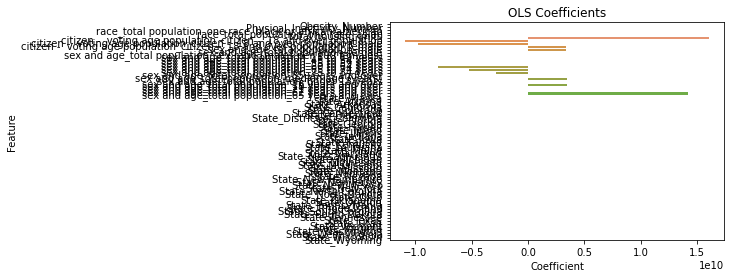

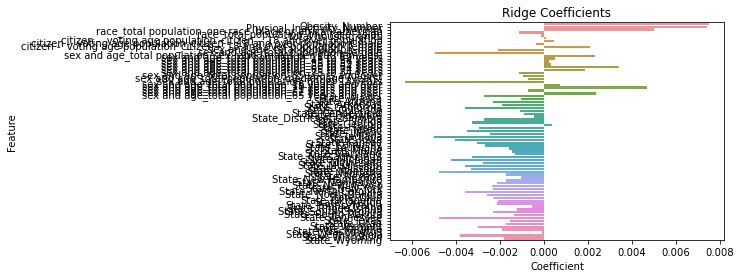

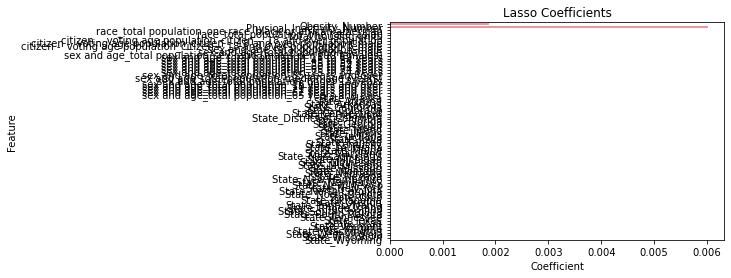

In [75]:
#Visualize Coefficients & Features - OLS
sns.barplot(x='Coefficient', y='Feature', data=lin_reg_data).set_title("OLS Coefficients")
plt.show()

#Visualize Coefficients & Features - Ridge
sns.barplot(x="Coefficient", y="Feature", data=ridge_reg_data).set_title("Ridge Coefficients")
plt.show()

#Visualize Coefficients & Features - Lasso
sns.barplot(x="Coefficient", y="Feature", data=lasso_reg_data).set_title("Lasso Coefficients")
plt.show()

### Comments for part 4.2:

When we look at the list of coefficients as well as the barplots of coefficients for our three models, we see that OLS coefficients are the smaller in magnitude than Ridge coefficients, both of which take all our features into account in fitting the model. Lasso, on the other hand, yields many zero coefficients as it is a model that automatically removes features. Thus, lasso takes only physical inactivity and obesity rates into account in fitting the model.

Not to mention that coefficients from this first step of fitting models to training set might be different after hyperparameter tuning, which we conduct in part 5.1.

## 5. Validate and Refine Models

### 5.1 Predict on Validation Set

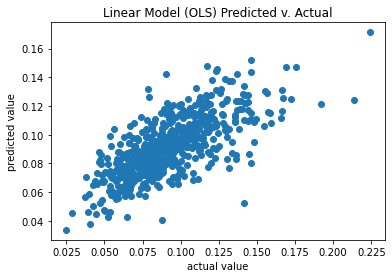

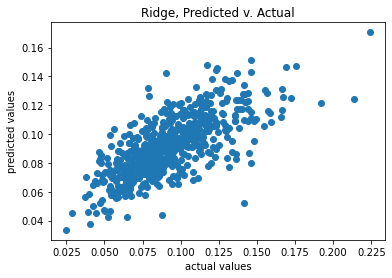

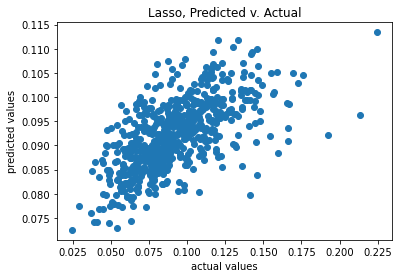

In [76]:
# use X_validation and y_validation data sets to evaluate and refine your models

# Prediction & Residuals Scatter Plot - OLS
lin_pred = lin_model.predict(X_validate)

plt.scatter(y_validate, lin_pred)
plt.title('Linear Model (OLS) Predicted v. Actual')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

# Prediction & Residuals Scatter Plot - Ridge
ridge_pred = ridge_model.predict(X_validate)

plt.scatter(y_validate, ridge_pred)
plt.title('Ridge, Predicted v. Actual')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

# Prediction & Residuals Scatter Plot - Lasso
lasso_pred = lasso_model.predict(X_validate)

plt.scatter(y_validate, lasso_pred)
plt.title('Lasso, Predicted v. Actual')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

**KQ**: nice job plotting the actual vs. predicted values here. 

In [77]:
# Calculating Root Mean Square Errors on Validation Set

# OLS
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))
print(rmse(lin_pred, y_validate))

# Ridge
print(rmse(ridge_pred, y_validate))

# Lasso
print(rmse(lasso_pred, y_validate))

0.019147199495687058
0.019130081552843053
0.023920459995272054


**KQ**: when you print out values, make sure to label them in the printed output so it's easier to tell which values refer to what

In [79]:
# Hyperparameter Tuning
# OLS
param_grid = {'fit_intercept': ['True', 'False'],
              'normalize': ['True', 'False']}

lin_grid_reg = GridSearchCV(lin_reg, param_grid, cv=3)
lin_grid_reg.fit(X_train, y_train)

best_index = np.argmax(lin_grid_reg.cv_results_["mean_test_score"])
best_lin_pred = lin_grid_reg.best_estimator_.predict(X_validate)

print(lin_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2, OLS:', max(lin_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2, OLS:', lin_grid_reg.score(X_validate, y_validate))
print('Validation RMSE, OLS', rmse(best_lin_pred, y_validate))

# RIDGE
param_grid = {'alpha': np.arange(.01, 1, .01),
              'normalize': ['True', 'False'],
              'fit_intercept': ['True', 'False'],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr']}

ridge_grid_reg = GridSearchCV(ridge_reg, param_grid, cv=3)
ridge_grid_reg.fit(X_train, y_train)

best_index = np.argmax(ridge_grid_reg.cv_results_["mean_test_score"])
best_ridge_pred = ridge_grid_reg.best_estimator_.predict(X_validate)

print(ridge_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2, Ridge:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2, Ridge:', ridge_grid_reg.score(X_validate, y_validate))
print('Validation RMSE, Ridge', rmse(best_ridge_pred, y_validate))

# LASSO
param_grid = {'alpha': np.arange(.01, 1, .01),
              'normalize': ['True', 'False'],
              'fit_intercept': ['True', 'False'],
              'selection': ['cyclic', 'random']}

lasso_grid_reg = GridSearchCV(lasso_reg, param_grid, cv=3)
lasso_grid_reg.fit(X_train, y_train)

best_index = np.argmax(lasso_grid_reg.cv_results_["mean_test_score"])
best_lasso_pred = lasso_grid_reg.best_estimator_.predict(X_validate)

print(lasso_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2, Lasso:', max(lasso_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2, Lasso:', lasso_grid_reg.score(X_validate, y_validate))
print('Validation RMSE, Lasso', rmse(best_lasso_pred, y_validate))

{'fit_intercept': 'True', 'normalize': 'True'}
Best CV R^2, OLS: -2.78778375009625e+58
Validation R^2, OLS: 0.5242428365439865
Validation RMSE, OLS 0.019147199495687058
{'alpha': 0.11, 'fit_intercept': 'True', 'normalize': 'True', 'solver': 'lsqr'}
Best CV R^2, Ridge: -0.3022996928014048
Validation R^2, Ridge: 0.5228878565099742
Validation RMSE, Ridge 0.01917444619712606
{'alpha': 0.01, 'fit_intercept': 'True', 'normalize': 'True', 'selection': 'cyclic'}
Best CV R^2, Lasso: -0.0014479879063390804
Validation R^2, Lasso: -0.0004956340499586709
Validation RMSE, Lasso 0.027766439466639033


**KQ**: nice job tinkering with the lasso hyperparameters to produce nonzero coefficients. 

### Comment for part 5.1:

Our best performing model is the same before and after hyperparameter tuning: 0.019 is the smallest RMSE on predicting on the validation set, from our ridge model after hyperparameter tuning.

### 5.2 Feature Selection

As mentioned above, we selected the ridge regression model based on the calculated RMSEs from the three models. Ridge regression, through its process of L2 regularization, adds an L2 norm penalty to spread out the coefficient values more equally compared to OLS regression. This allows ridge regression to integrate feature selection by bringing erroneous coefficients close to zero. The feature selection is done conceptually through this process. We did some additional feature selection above by setting the variance threshold to zero. This allows us to reduce erroneous features not in accordance with the established threshold. Lasso already performs automated feature selection as seen in the zero coefficients of barplots in part 4.1


### 5.3 Test Set

In [81]:
# Choosing the best model with best hyperparameter values
# RIDGE
best_pred = ridge_grid_reg.best_estimator_.predict(X_test)
print('Best CV R^2, Ridge:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Test R^2, Ridge:', ridge_grid_reg.score(X_test, y_test))
print('Test RMSE, Ridge', rmse(best_pred, y_test))

Best CV R^2, Ridge: -0.3022996928014048
Test R^2, Ridge: 0.4793206487612526
Test RMSE, Ridge 0.020088019140449217


### 5.4 Cross-Validation Approach

We observed by trying different number of folds that as the number of folds increase, the cross-validation error decreases: from 0.0228 (cv = 3) to 0.0227 (cv = 6) to  0.0223 (cv = 10) to 0.0221 (cv = 15). On the other hand, 20 folds yields increasing errors (0.0222).

We see below that cross validation approach does not reduce the prediction error as much as splitting the data into training-validation-test sets, even when we pick the number of folds (in this case 15) that yields the smallest cross-validation error. This might be explained by how increasing the size of training set is beneficial in getting the best fit without overfitting, as the model is trained to cover and fit a larger portion of the data.

In [82]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

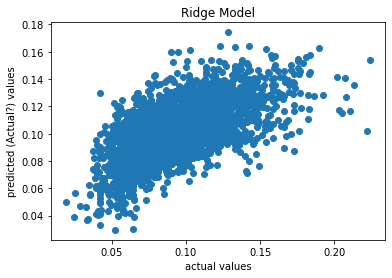

RMSE: 0.02425916901613321


In [83]:
ridge_pred = cross_val_predict(ridge_reg, X, y, cv = 10)

# plot the predictions
plt.scatter(y, ridge_pred)
plt.title('Ridge Model')
plt.xlabel('actual values')
plt.ylabel('predicted (Actual?) values')
plt.show()

# calculate the rmse for the Ridge model
print('RMSE:', rmse(ridge_pred, y))

[ 7.49750850e-03  7.37754860e-03  4.97770498e-03 -1.12818428e-03
 -1.34091570e-04  9.49552173e-05  4.47860219e-04 -3.44343885e-04
  2.08308466e-03 -2.08308466e-03 -4.94995029e-03  2.30082154e-03
  5.16723147e-04  2.42701162e-04  3.05668973e-04  3.38136226e-03
  1.86997609e-03 -1.13413912e-03 -9.45161162e-04 -7.27383134e-04
 -6.32531927e-03  7.27383134e-04  4.66728653e-03 -7.16780470e-04
  2.36960755e-03 -2.72006070e-03 -1.06628910e-03 -2.31383788e-03
 -1.89846536e-03 -3.56852559e-03 -1.09122428e-03 -8.99213197e-04
 -4.49628470e-04 -2.71795774e-03 -3.26092206e-03  3.69301163e-04
 -2.95707281e-03 -3.49289503e-03 -2.45846325e-03 -5.01299065e-03
 -4.03009107e-03 -3.04697671e-03 -2.68077533e-03 -1.60459114e-03
 -1.44922062e-03 -1.33016142e-03 -3.25956621e-03 -4.23138131e-03
 -2.79039924e-03 -3.58433832e-03 -3.30860274e-03 -4.78782039e-03
 -1.72032495e-03 -1.04370555e-03 -1.72828791e-03 -2.14707966e-03
 -2.37485992e-03 -2.31837702e-03 -3.59832760e-03 -2.57144823e-03
 -2.30471152e-03 -2.10693

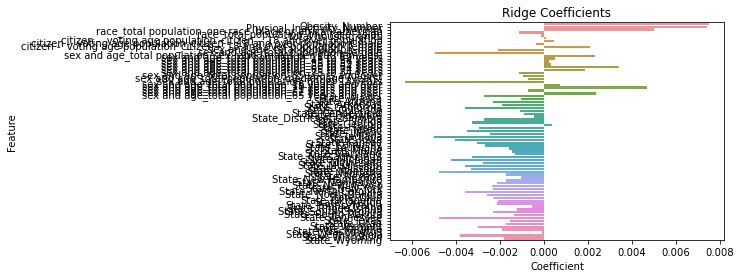

In [84]:
print(ridge_reg.coef_)
print(ridge_reg.intercept_)

ridge_reg_coef = pd.DataFrame([ridge_reg.coef_, Xdf.columns]).T
ridge_reg_coef.columns = ['Coefficient', 'Feature']

sns.barplot(x="Coefficient", y="Feature", data=ridge_reg_coef).set_title("Ridge Coefficients")
plt.show()

## 6. Discussion Questions

#### 6.1 What is bias-variance tradeoff? Why is it relevant to machine learning problems like this one?

Machine learning methods allow us to make predictions based on previously collected data. We can analyze certain data points or variables to make predictions about a potential outcome. To analyze data, machine learning methods utilize a variety of different statistical models. There is no such thing as a perfect statistical model, but we can select a model that works the best for our given data. Our goal is to select the best model that allows us to make the best predictions while also producing the least amount of error. Two prediction errors involve the concepts of bias and variance.
Bias involves the difference between the actual values and the predicted values our selected model generates. Variance involves the degree to which the model’s predictions fluctuate given the data that shapes our selected model. High bias can lead to underfitting where the guiding previously collected data points are oversimplified; their complexity and relationship to each other is given little attention. High variance can lead to overfitting where our selected model pays too much attention to the random variation naturally found in our guiding previously collected data points.
We want to avoid underfitting and overfitting when selecting the best model to generate our predictions. To do this, we must find a balance between bias and variance errors in our model selection process. The bias-variance tradeoff describes this negotiation in finding the right balance so our model is not oversimplified (underfitting) but also not too sensitive (overfitting).


**KQ**: nice job here. 

#### 6.2 Define overfitting, and why it matters for machine learning. How can we address it?

Overfitting occurs when the machine learning model that makes predictions on the training data set has high variance. In other words, the model learns or “fits” the training data so well, including the noise, that it cannot generalize well to make predictions on other data (e.g., new data, or unseen data like the test data set). Simply put, a model that has low bias and high variance, or overfits the data it was trained on, is not good for generating predictions on other samples (i.e., if we apply the model to another sample it will have poor predictive power). Overfitting can happen when there are too many features (predictors) in the data set (high dimensionality), making a very complicated model.
We can address overfitting by reducing the number of features, especially the ones that are highly correlated with each other. We can also tackle overfitting by fitting multiple models and using validation or cross-validation to compare their predictive accuracies on test data. Lastly, regularization can help address overfitting by keeping all of the features but imposing a constraint (penalty) on the magnitude of the coefficients. Regularization allows us to not lose features by assigning penalties to constrain the coefficients (setting them to smaller values), producing a smooth function and ensuring the model is not overfitting on the training data. Lasso and Ridge are two regularization algorithms. Ridge adds the square of the magnitude of the coefficients as a penalty. Lasso adds the absolute of the magnitude of the coefficients as a penalty, which means that some of the coefficients will end up being zero; therefore, lasso can completely eliminate non-important features (i.e., their data will not be used in the algorithm).

**KQ**: very thorough discussion of overfitting and approaches to reduce it, specifcially around feature selection, crossvalidation, and regularization. 

#### 6.3 Discuss your Analysis in 2-3 Paragraphs

In the first step of preparing our data for training, we transformed state and county indicators into dummy variables, centered our numeric variables around the mean by rescaling them and removed zero-variance features. Once the data was ready for EDA, our initial findings in this phase demonstrated that, looking at rankings of diabetes- as well as physical inactivity and obesity rates which are both strongly correlated with diabetes- the region at risk both at the state and county level is the South(East) of the country. [As we will explain, these exploratory findings are in line with our final predictions of our chosen model. The following three paragraphs will provide a technical summary of our analysis and findings, while the final paragraph will discuss policy implications of our findings.]

EDA further revealed that counties where black & African American people are a higher proportion of the population are more likely to have high diabetes rates, while the relative population of Asians is negatively correlated with diabetes in a county. While there seems to be some correlation between other general racial groups (white, latinx, AIAN, NHPI and other) and diabetes, the slopes of the regression line for these groups seems to be not as upward/downward looking as the black & African American and Asian groups, and mostly sensitive to outliers. Therefore we remove all racial groups except those in the first feature selection phase before training our models. Similarly, looking at regression lines of age groups, variables indicating the 20-44 year old range as well as 0-15 year old range seem to be not worth taking into account for sake of simplicity in our models. Finally, we also removed features indicative of gender as these also look uncorrelated with diabetes, our label. 

Once our features were in the right format for analysis and feature selection was completed, we split our data into training, validation and test sets (see 3.2 for trade-offs involved in splitting our data). We used the training set encompassing 60% of our data, and listed coefficients from all three models that we fit to the training set. We observed that Lasso estimated zero coefficients for all except two features: physical inactivity and obesity rate. Because Lasso automatically eliminates insignificant coefficients, this result doesn’t surprise us and is in line with our EDA. The coefficients of Ridge and OLS models were overall smaller, with OLS yielding smallest coefficients (see 4.2)

We then tested the predictive performance of each model on the validation set, with the smallest error (RMSE) given by the Ridge. After hyperparameter tuning and re-testing all three models on the validation set, Ridge again yielded the smallest error. The differences between errors from predicting on validation set (0.019) and test set (0.020) were very close, indicating predictive performance. Finally, we tried to see if cross-validation can provide better predictive accuracy than the train/validate/test approach and tried multiple numbers of folds in cross-validation between 3 and 20. However, the smallest error from these predictions (0.022) was still larger. 

As the final list and barplot of coefficients of features show above part 6, the features that stand out as having the largest predictive effect are obesity rate and physical inactivity, as well as ratio of population over the age of 45 and ratio of population that is black & African American. We had also found during EDA that highest diabetes rates were in South Eastern states, and highest ranking counties were overwhelmingly in these southern states. These findings together demonstrate that, policy makers should focus their efforts in the south, targeting underlying social health conditions leading to obesity and physical inactivity in the first place.

With regard to sensitive features such as rage, gender and age; we found race for certain populations worth considering based on EDA. In predicting a public health outcome like diabetes, age inevitably factors into prediction and policy intervention. Gender composition the other hand did not seem significantly correlated with diabetes rate. While we feel comfortable taking into account sensitive features in our models, policy makers should take into account which other factors other than racial and age composition of southern states contribute to high diabetes rates. In applications of this model in other settings, public health and demographic setting of different areas should be evaluated differently.

**KQ**: nice job, folks! Which counties would you recommend the program target?